In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.linalg import toeplitz


d1 to d5 are binary variable representing monday to friday

In [3]:
df = pd.read_csv('STI_1994-2002.csv') ### need to ensure numbers are in numbers, not general or other formats in CSV
df=df.dropna()
df.reset_index(inplace=True, drop=True) ### inplace=True changes index to 0,1,2,..., drop=True removes old index of 1,2,3,
df

,Date,Day,index level,contcpdret,d1,d2,d3,d4,d5
0,12/7/1994,Tuesday,1777.27,0.007976,0,1,0,0,0
1,13/7/1994,Wednesday,1796.27,0.010634,0,0,1,0,0
2,14/7/1994,Thursday,1815.75,0.010786,0,0,0,1,0
3,15/7/1994,Friday,1826.39,0.005843,0,0,0,0,1
4,18/7/1994,Monday,1830.93,0.002483,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2154,14/10/2002,Monday,1378.44,0.003452,1,0,0,0,0
2155,15/10/2002,Tuesday,1429.68,0.036498,0,1,0,0,0
2156,16/10/2002,Wednesday,1439.05,0.006533,0,0,1,0,0
2157,17/10/2002,Thursday,1466.02,0.018568,0,0,0,1,0


# OLS

In [4]:
### Choose first half of data
data1 = df.iloc[0:1079,]
formula = 'contcpdret ~ d1 + d2 + d3 + d4 + d5 - 1' #The - 1 at the end of the formula indicates that the model should not include an intercept term, which is typically included by default
results = ols(formula, data1).fit()
print(results.summary())

### Note: adding ' -1 ' removes constant or intercept
### Note that if we remove the  - 1, this statsmodel program still runs and shows regression results,
###   but warns of singular matrix -- other programs e.g. R would not return any result

                            OLS Regression Results                            
Dep. Variable:             contcpdret   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.935
Date:                Mon, 05 Feb 2024   Prob (F-statistic):              0.102
Time:                        19:50:02   Log-Likelihood:                 3094.4
No. Observations:                1079   AIC:                            -6179.
Df Residuals:                    1074   BIC:                            -6154.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d1            -0.0024      0.001     -2.605      0.0

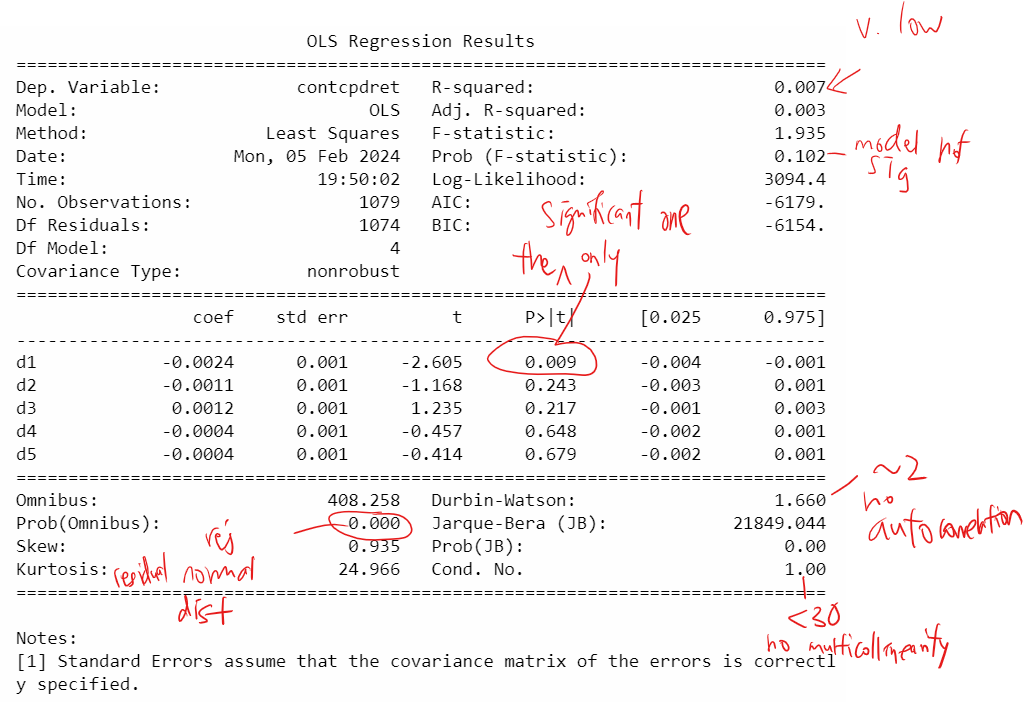

In [17]:
sigma=np.std(results.resid)

B=results.params
b=B.to_numpy() ### first, convert to numpy array
beta = b.reshape(5, 1)

bigX = data1[['d1','d2','d3','d4','d5']].to_numpy()

bigXT = bigX.T ### bigXT.shape is (5,1079)
XX = (bigXT).dot (bigX)
R = np.array([[1, 0, 0, 0, -1],[0, 1, 0, 0, -1],[0, 0, 1, 0, -1],[0, 0, 0, 1, -1]])
r = np.array([[0],[0],[0],[0]])

M = R.dot(np.linalg.inv(XX)).dot(R.T)
F=(((R.dot (beta)-r).T).dot(np.linalg.inv(M)).dot(R.dot (beta)-r)/4)/((1079/1074)*(sigma)**2)
print(F)
### Note this is F with d.f. 4, N-k 

f=F
dfn=4
dfd=1079-5
p = 1-scipy.stats.f.cdf(f, dfn, dfd)
print('p value of f stats to test whether effect of b1 to b4 statistically diff from effect of b4 = ', p)

[[1.93458638]]
p value of f stats to test whether effect of b1 to b4 statistically diff from effect of b4 =  [[0.10248109]]


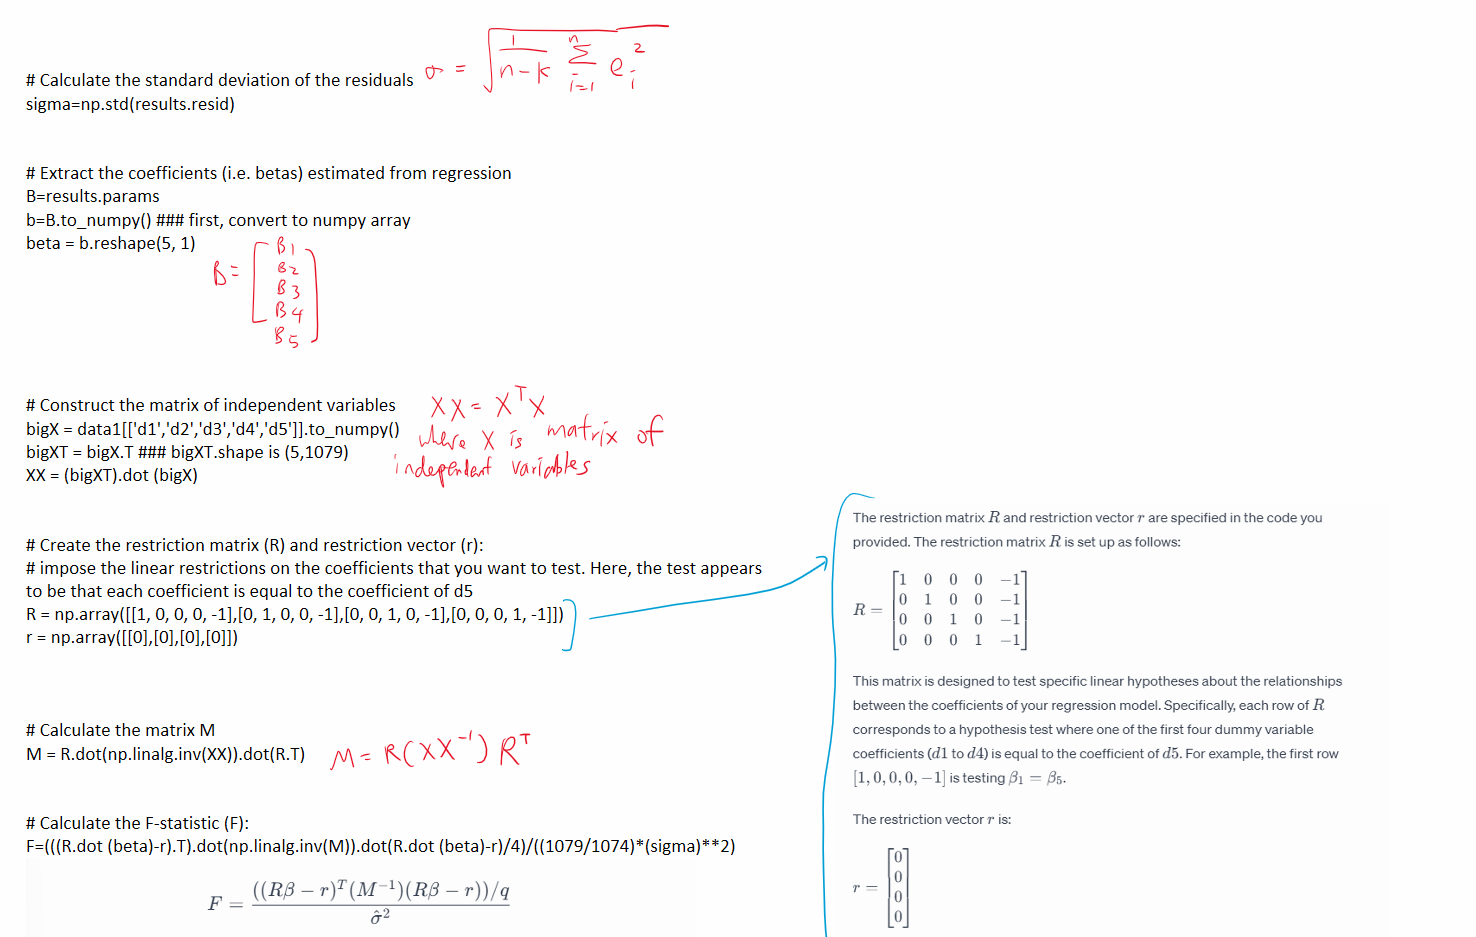
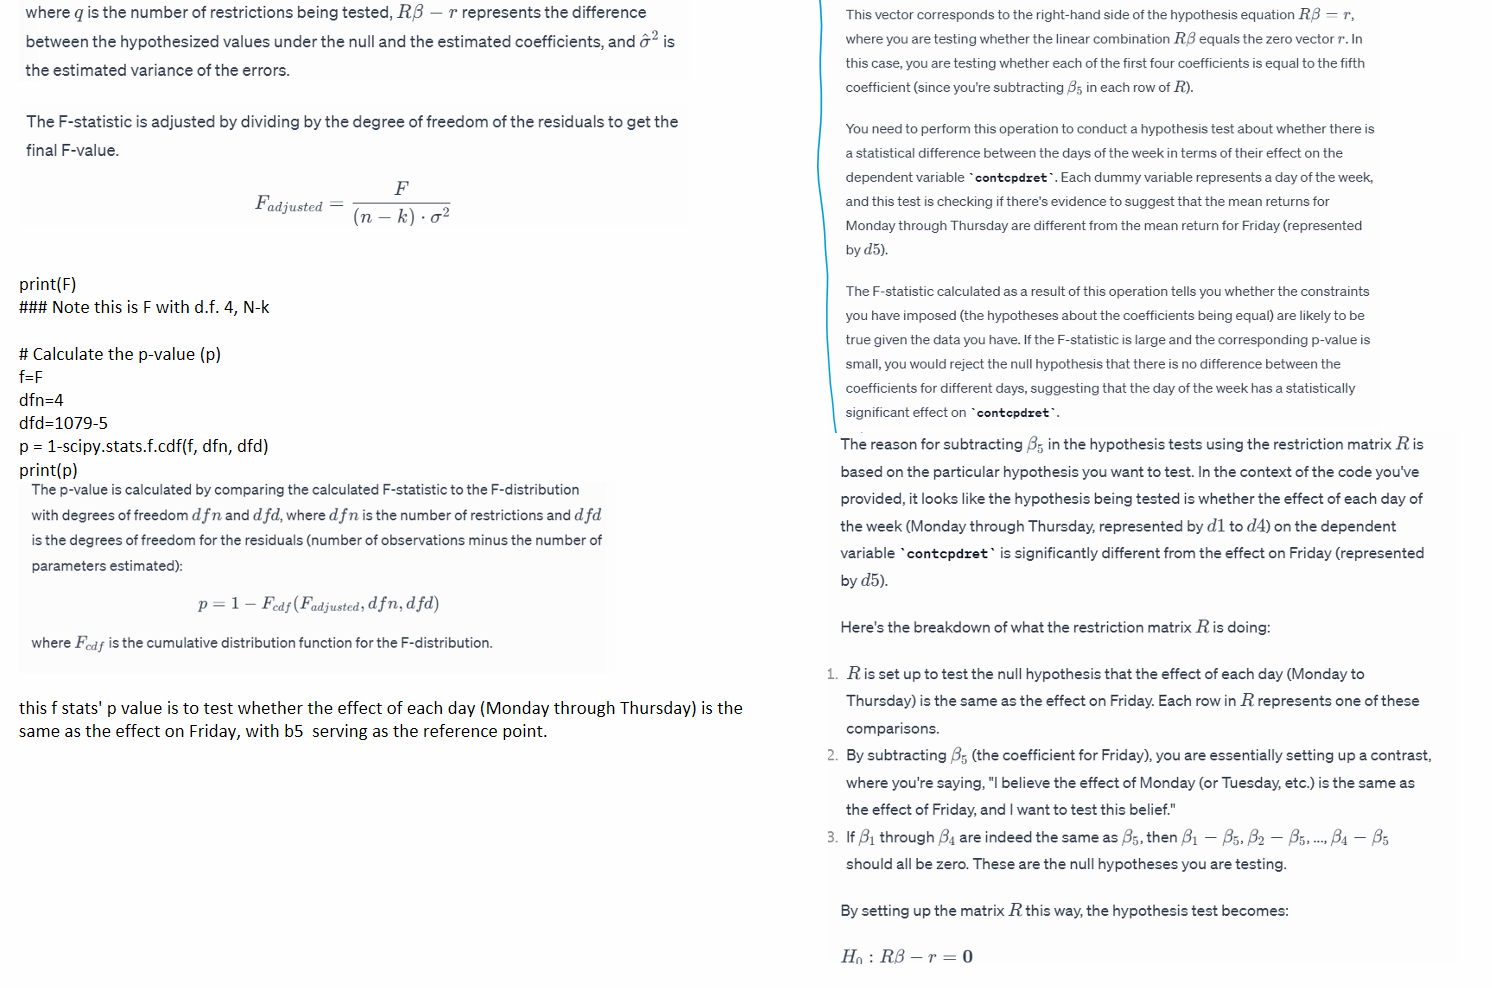
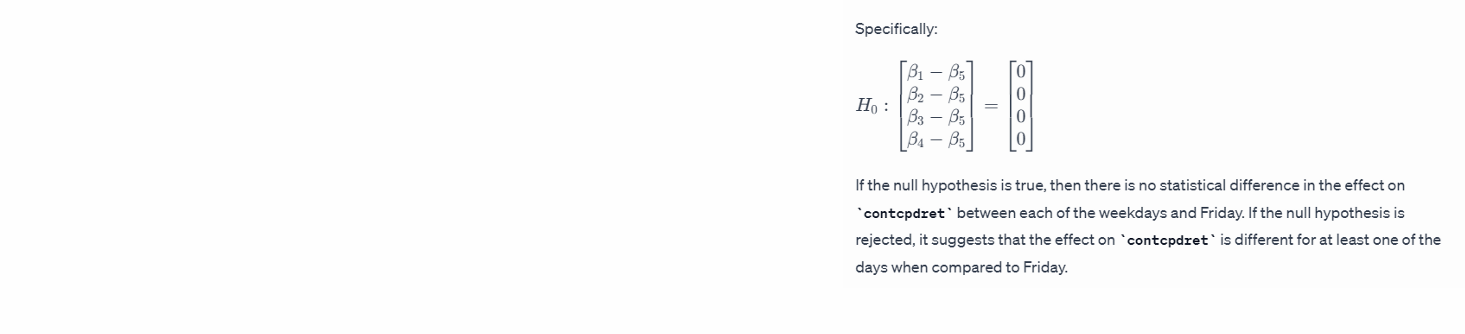

# Breusch-Pagan test for heteroskedasticity in a regression model (standard undesirable h0: no heteroskedasticity)
- Heteroskedasticity refers to the circumstance in which the variance of the errors from a regression model is not constant across all levels of the independent variables. If present, it can lead to inefficiency of estimates and problems with statistical inference.
- **dummy varaible trap (if we know the dummy variable b2 to b5, we can predict whats the dummy variable of b1. there is multicollinearity)**: The "dummy variable trap" is a scenario where independent variables are multicollinear, meaning one variable can be predicted from the others, leading to redundant information. This typically occurs when dummy variables are created for a categorical variable but all the categories (or levels) are included as separate dummy variables without omitting one.

In [16]:
One=np.ones([len(data1['d1']),1])
One=pd.DataFrame(One)
Dx=pd.concat([data1['d1'],data1['d2'],data1['d3'],data1['d4'],data1['d5']],axis=1)
Dx1=pd.concat([One,data1['d2'],data1['d3'],data1['d4'],data1['d5']],axis=1)  ### leaves out d1 to avoid dummy var trap


### Test for Heteroskedasticity
X = sm.add_constant(Dx)

bp_test = het_breuschpagan(results.resid, X)
print('LM-test chi-sq:', bp_test[0], 'LM-test p_value:', bp_test[1])
### This tests with 4 deg freedom
### It is similar to testing constraint of reg resid^2 coefs on d2, d3, d4, d5 = 0. One df is dropped as regression of hat u^2
###  requires to accommodate a positive constant. Hence not 5 d.f.

### Test for Heteroskedasticity
bp_test = het_breuschpagan(results.resid,Dx1)
print ('LM-test chi-sq:', bp_test[0], 'LM-test p_value:', bp_test[1])
### This tests with 4 deg freedom
### Breusch-Pagan test auxiliary regression with formula \hat{e}_{i}^{2}=\hat{\gamma}_{0}+\hat{\gamma}_{1}x_{1i}
###   +\hat{\gamma}_{2}x_{2i}\;(3) and chi-square test with joint null hypothesis that independent variables coefficients 
###   are equal to zero with formula H_{0}:\hat{\gamma}_{1}=\hat{\gamma}_{2}=0\; hence test is chi-sq with d.f. equal to 
###   number of coeffs in linear reg model less 1 (i.e. less the intercept). 
### Testing constraint of reg resid^2 coefs on d2, d3, d4, d5 = 0, d.f. = 4. Negligible Numerical diff with case of DX

LM-test chi-sq: 6.7673334623424335 LM-test p_value: 0.238527006181411
LM-test chi-sq: 6.7673334623424335 LM-test p_value: 0.14870642721331156


# GLS
- Generalized Least Squares, which is a statistical method that extends ordinary least squares (OLS) to models with certain types of heteroskedasticity or autocorrelation. While OLS assumes that the errors are both homoskedastic (constant variance across observations) and uncorrelated with each other, GLS allows relaxation of these assumptions.

In [21]:
resid_fit = sm.OLS(
    np.asarray(results.resid)[1:], sm.add_constant(np.asarray(results.resid)[:-1])
).fit()
rho = resid_fit.params[1] #  value between -1 and 1 representing the correlation between errors at different observations
trix = toeplitz(range(len(results.resid))) ### trix is sq matrix with zero in diag, 1 in first off diag, 2 in 2nd off diag, etc.
# Toeplitz matrix, which is a matrix where each descending diagonal from left to right is constant.

sigma = rho ** trix ### create a covariance matrix for the residuals, assuming a particular structure of autocorrelation that depends on a parameter rho
gls_model = sm.GLS(data1['contcpdret'], Dx, sigma=sigma) # a GLS model is being set up using the dependent variable contcpdret, the matrix of independent variables Dx, and the covariance matrix sigma
gls_results = gls_model.fit()

In [24]:
gls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:             contcpdret   R-squared:                       0.008
Model:                            GLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.064
Date:                Mon, 05 Feb 2024   Prob (F-statistic):             0.0834
Time:                        21:47:10   Log-Likelihood:                 3109.9
No. Observations:                1079   AIC:                            -6210.
Df Residuals:                    1074   BIC:                            -6185.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d1            -0.0025      0.001     -2.619      0.009      -0.004      -0.001
d2            -0.0011      0.001     -1.172      0.242      -0.003       0.001
d3             0.0012      0.001      1.235      0.217      -0.001       0.003
d4            -0.0004      0.001     -0.457      0.648      -0.002       0.001
d5            -0.0004      0.001     -0.412      0.680      -0.002       0.001
==============================================================================
Omnibus:                      502.592   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25362.761
Skew:                           1.370   Prob(JB):                         0.00
Kurtosis:                      26.593   Cond. No.                         1.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

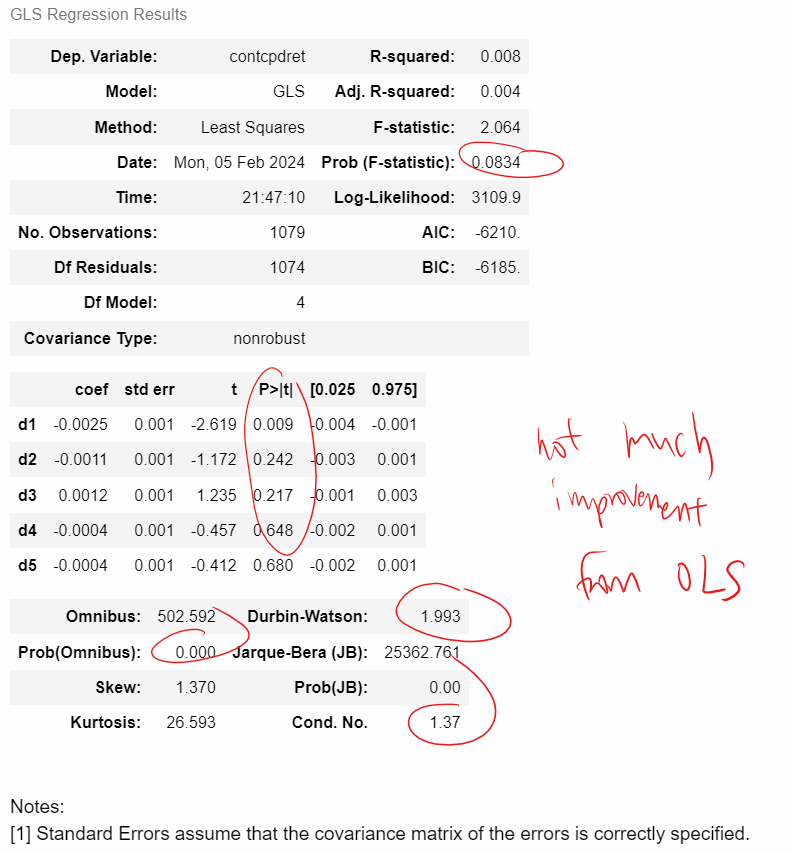

# HAC (heteroskedasticity-autocorrelation consistent cov estimator)
- HAC estimators are used to adjust the standard errors of the coefficients in a regression model to account for heteroskedasticity, providing more reliable statistical inference (e.g., for hypothesis testing or constructing confidence intervals).
-  in a setting where there is no heteroskedasticity, using robust standard errors might not provide any benefit over traditional standard errors and could potentially lead to less efficient estimates.

In [25]:
model = sm.OLS(data1['contcpdret'], Dx)
ols_hc = model.fit(cov_type="HC3")
print(ols_hc.summary())

                            OLS Regression Results                            
Dep. Variable:             contcpdret   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 05 Feb 2024   Prob (F-statistic):                nan
Time:                        22:37:54   Log-Likelihood:                 3094.4
No. Observations:                1079   AIC:                            -6179.
Df Residuals:                    1074   BIC:                            -6154.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
d1            -0.0024      0.001     -1.966      0.0